<a href="https://colab.research.google.com/github/zugbaa/znanstveni_rad/blob/main/fast_DE_ansambl_GOOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras tensorflow
!pip install pandas openpyxl
!pip install arch

import numpy as np
import gc
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.dates as mdates
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import random
import seaborn as sns
import warnings

drive.mount('/content/drive')
file_path_prices = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/Google_historical_data.csv'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 14.2 MB/s eta 0:00:00
Mounted at /content/drive


#Datasets

In [ ]:
# price data

df_prices = pd.read_csv(file_path_prices)
features_to_shift = [
  "Adj_Close"
]
df_prices['today_price'] = df_prices['Adj_Close']
df_prices[features_to_shift] = df_prices[features_to_shift].shift(1)
df_prices['prediction'] = df_prices['today_price'] -  df_prices['Adj_Close']
df_prices['price_diff'] = df_prices['prediction'].shift(1)
df_prices = df_prices[(df_prices['Date'] >= '2015-01-01') & (df_prices['Date'] <= '2020-01-01')]

In [ ]:
# tweet data

file_path_tweet = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/Google_avg_sentiment.csv'
tweet_data = pd.read_csv(file_path_tweet)
features_to_shift = [ "Adj_Close","avg_score","std_score" ]
tweet_data['today_price'] = tweet_data['Adj_Close']
tweet_data[features_to_shift] = tweet_data[features_to_shift].shift(1)
tweet_data['prediction'] = tweet_data['today_price'] - tweet_data['Adj_Close']
tweet_data['price_diff'] = tweet_data['prediction'].shift(1)
features_to_keep_tweet = [ "Date","Adj_Close","avg_score","std_score", "today_price", "price_diff", 'prediction' ]
tweet_data = tweet_data[features_to_keep_tweet]
tweet_data.dropna(inplace=True)

In [ ]:
# technical data

file_path_ta = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/Google_historical_data.csv'
ta_data = pd.read_csv(file_path_ta)
features_to_shift_ta = [
    "Open", "High", "Low", "Close", "Adj_Close", "Volume",
    "Accumulation_Distribution_Line", "On_Balance_Volume",
    "Average_Directional_Index", "Aroon_Oscillator", "MACD",
    "RSI", "Stochastic_Oscillator", "Simple_Moving_Average",
    "Exponential_Moving_Average", "Williams_%R"
]
ta_data['today_price'] = ta_data['Adj_Close']
ta_data[features_to_shift_ta] = ta_data[features_to_shift_ta].shift(1)
ta_data['prediction'] = ta_data['today_price'] -  ta_data['Adj_Close']
ta_data['price_diff'] = ta_data['prediction'].shift(1)
features_to_keep_ta = [
    "Date","Open", "High", "Low", "Close", "Adj_Close", "prediction","Volume",
    "Accumulation_Distribution_Line", "On_Balance_Volume",
    "Average_Directional_Index", "Aroon_Oscillator", "MACD",
    "RSI", "Stochastic_Oscillator", "Simple_Moving_Average",
    "Exponential_Moving_Average", "Williams_%R", 'today_price', 'price_diff'
]
ta_data = ta_data[features_to_keep_ta]
ta_data = ta_data[(ta_data['Date'] >= '2015-01-01') & (ta_data['Date'] <= '2020-01-01')]

In [ ]:
# fundumental data

file_path_fund = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/GOOG_fund_data.csv'
fund_data = pd.read_csv(file_path_fund)
features_to_shift_fund = [
  "Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity"
]
fund_data['today_price'] = fund_data['Adj_Close']
fund_data[features_to_shift_fund] = fund_data[features_to_shift_fund].shift(1)
fund_data['prediction'] = fund_data['today_price'] -  fund_data['Adj_Close']
fund_data['price_diff'] = fund_data['prediction'].shift(1)
features_to_keep_fund = [
  "Date","Adj_Close","Revenue","Net_Income","EPS","Gross_Profit_Margin",
  "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
  "Total_Assets","Total_Liabilites","Shareholders_Equity", "today_price", "price_diff", 'prediction'
]
fund_data = fund_data[features_to_keep_fund]
fund_data.dropna(inplace=True)

In [ ]:
# time series data

file_path_time = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/Google_historical_data.csv'

time_data = pd.read_csv(file_path_time)

features_to_shift_time = [ "yesterday_price" ]

time_data['yesterday_price'] = time_data['Adj_Close']
time_data[features_to_shift_time] = time_data[features_to_shift_time].shift(1)
time_data['price_diff'] = time_data['yesterday_price'] -  time_data['Adj_Close']

time_data = time_data[(time_data['Date'] >= '2015-01-01') & (time_data['Date'] <= '2020-01-01')]
features_to_keep = ["Date","Adj_Close", 'yesterday_price', 'price_diff']
time_data = time_data[features_to_keep]
time_data = time_data.reset_index(drop=True)

# Time series model

In [ ]:
warnings.filterwarnings("ignore")

class TimeSeriesModel:

    def __init__(self):
        self.p = 3
        self.d = 1
        self.q = 3
        self.garch_order = (4, 1)
        self.predicted_values = []

    def train_model(self, data):
        train_size = int(len(data) * 0.80)
        for i in range(train_size, len(data)-1):
            train_data = data.iloc[:i]
            test_data = data.iloc[i:i+1]

            arima_model = ARIMA(train_data['Adj_Close'].values, order=(self.p, self.d, self.q))
            arima_model_fit = arima_model.fit()
            predicted_mu = arima_model_fit.forecast(steps=1)[0]

            garch_model = arch_model(arima_model_fit.resid, vol='Garch', p=self.garch_order[0], q=self.garch_order[1])
            garch_model_fit = garch_model.fit(disp='off')

            predicted_et = garch_model_fit.forecast(horizon=1)
            predicted_et = predicted_et.mean.iloc[-1, 0]

            prediction = predicted_mu + predicted_et

            prediction = test_data['yesterday_price'].values[0] - prediction
            self.predicted_values.append(prediction)

    def walk_forward_validation(self, data):
          train_data = data.iloc[:-1]
          test_data = data.iloc[-1]

          arima_model = ARIMA(train_data['Adj_Close'].values, order=(self.p, self.d, self.q))
          arima_model_fit = arima_model.fit()

          predicted_mu = arima_model_fit.forecast(steps=1)[0]

          garch_model = arch_model(arima_model_fit.resid, vol='Garch', p=self.garch_order[0], q=self.garch_order[1])
          garch_model_fit = garch_model.fit(disp='off')

          predicted_et = garch_model_fit.forecast(horizon=1)
          predicted_et = predicted_et.mean.iloc[-1, 0]

          prediction = predicted_mu + predicted_et
          prediction = test_data['yesterday_price'] - prediction

          self.predicted_values.append(prediction)

          return self.predicted_values

# Fundumental model

In [ ]:
class FundumentalModel:

    def __init__(self):
        self.indicators_to_keep = [
            "price_diff","Revenue","Net_Income","EPS","Gross_Profit_Margin",
            "Operating_Margin","Net_Profit_Margin","Cash_Flow_From_Operations",
            "Total_Assets","Total_Liabilites","Shareholders_Equity"
            ]
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    def train_model(self, data):
        train_size = int(len(data) * 0.80)
        train_data = data.iloc[:train_size]
        train_data = train_data[self.indicators_to_keep]
        X_train = train_data
        y_train = data.iloc[:train_size]["prediction"]
        rf_model = RandomForestRegressor(max_depth= 50, max_features=None, min_samples_leaf=2, min_samples_split=50, n_estimators=100, random_state=42, verbose=0)
        rf_model.fit(X_train, y_train)
        return rf_model

    def walk_forward_validation(self, data, rf_model):
        train_size = int(len(data) * 0.80)
        test_data = data[train_size:]
        test_data = test_data[self.indicators_to_keep]
        forecast = rf_model.predict(test_data)

        return forecast

#Technical model

In [ ]:
class TechnicalModel:

    def __init__(self):
        self.indicators_to_keep = [
            "Open", "High", "Low", "Close", "Adj_Close","Volume",
            "Accumulation_Distribution_Line", "On_Balance_Volume",
            "Average_Directional_Index", "Aroon_Oscillator", "MACD",
            "RSI", "Stochastic_Oscillator", "Simple_Moving_Average",
            "Exponential_Moving_Average", "Williams_%R", 'price_diff'
            ]
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    def train_model(self, data):
        train_size = int(len(data) * 0.80)
        train_data = data.iloc[:train_size]
        train_data = train_data[self.indicators_to_keep]
        X_train = train_data
        y_train = data.iloc[:train_size]["prediction"]
        rf_model = RandomForestRegressor(max_depth= 50, max_features=None, min_samples_leaf=2, min_samples_split=50, n_estimators=100, random_state=42, verbose=0)
        rf_model.fit(X_train, y_train)
        return rf_model

    def walk_forward_validation(self, data, rf_model):
        train_size = int(len(data) * 0.80)
        test_data = data[train_size:]
        test_data = test_data[self.indicators_to_keep]
        forecast = rf_model.predict(test_data)

        return forecast

# tweet model

In [ ]:
class TweetModel:

    def __init__(self):
        self.indicators_to_keep = [
          "price_diff","avg_score","std_score"
          ]
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    def train_model(self, data):
        train_size = int(len(data) * 0.80)
        train_data = data.iloc[:train_size]
        train_data = train_data[self.indicators_to_keep]
        X_train = train_data
        y_train = data.iloc[:train_size]["prediction"]
        rf_model = RandomForestRegressor(max_depth= 50, max_features=None, min_samples_leaf=2, min_samples_split=50, n_estimators=100, random_state=42, verbose=0)
        rf_model.fit(X_train, y_train)
        return rf_model

    def walk_forward_validation(self, data, rf_model):
        train_size = int(len(data) * 0.80)
        test_data = data[train_size:]
        test_data = test_data[self.indicators_to_keep]
        forecast = rf_model.predict(test_data)

        return forecast

In [ ]:
# removing first two rows so that all datasets have the same number of days
df_prices = df_prices.iloc[2:]
time_data = time_data.iloc[2:]
ta_data = ta_data.iloc[2:]

train_size = int(len(df_prices) * 0.80)

In [ ]:
class DifferentialEvolution:

    def __init__(self, population_size, max_nfes, crossover_rate, scale_factor, loc, scale, bound_handler):
        self.population_size = population_size
        self.max_nfes = max_nfes
        self.crossover_rate = crossover_rate
        self.scale_factor = scale_factor
        self.bound_handler = bound_handler
        self.crossover_rates = [crossover_rate] * self.population_size
        self.scale_factors = [scale_factor] * self.population_size
        self.loc = loc
        self.scale = scale
        self.name = "DE"

    def search(self, experiment_name, fitness_function):
        spent_nfes = 0
        interval = (self.bound_handler.upper_bound - self.bound_handler.lower_bound)

        population = np.random.rand(self.population_size, fitness_function.n)
        population = population / np.sum(population, axis=1, keepdims=True)
        population_fitness = np.empty(self.population_size, float)

        for idx, candidate in enumerate(population):
            population_fitness[idx] = fitness_function.evaluate(candidate)
            spent_nfes += 1

        trial_population = np.empty_like(population)
        trial_population_fitness = np.empty(self.population_size, float)

        while spent_nfes < self.max_nfes:
            if spent_nfes % self.population_size == 0:
                self._adjust_control_parameters()

            for idx, candidate in enumerate(population):
                mutant = self._create_mutant_vector(idx=idx, population=population, population_fitness=population_fitness)
                trial = self._create_trial_vector(idx, mutant, candidate)
                trial_population[idx] = trial

            for idx, trialCandidate in enumerate(trial_population):
                trial_population_fitness[idx] = fitness_function.evaluate(trialCandidate)
                spent_nfes += 1

                if spent_nfes >= self.max_nfes:
                    break

            should_swap = trial_population_fitness <= population_fitness

            for idx, swap in enumerate(should_swap):
                if swap:
                    population[idx] = trial_population[idx].copy()
                    population_fitness[idx] = trial_population_fitness[idx]

            if spent_nfes >= self.max_nfes:
                best_idx = np.argmin(population_fitness)
                #print("Best RMSE: {0}".format(population_fitness[best_idx]))
                return population[best_idx], population_fitness[best_idx]

    def _create_trial_vector(self, idx, mutant, candidate):
        should_cross = np.random.rand(len(candidate)) <= self.crossover_rates[idx]

        random_index = int(len(candidate) * random.random())
        should_cross[random_index] = True

        trial = np.where(should_cross, mutant, candidate)
        self.bound_handler.handle_bounds(trial)
        return trial

    def _create_mutant_vector(self, population, idx, population_fitness):
        r1, r2, r3 = self._select_mutation_vectors(idx)
        f1 = population_fitness[r1]
        f2 = population_fitness[r2]
        f3 = population_fitness[r3]
        if f1 <= f2 and f1 <= f3:
            return population[r1] + self.scale_factors[idx] * (population[r2] - population[r3])
        elif f2 <= f1 and f2 <= f3:
            return population[r2] + self.scale_factors[idx] * (population[r1] - population[r3])
        else:
            return population[r3] + self.scale_factors[idx] * (population[r1] - population[r2])

    def _select_mutation_vectors(self, idx):
        r1 = int(self.population_size * random.random())
        while r1 == idx:
            r1 = int(self.population_size * random.random())

        r2 = int(self.population_size * random.random())
        while r2 == idx or r2 == r1:
            r2 = int(self.population_size * random.random())

        r3 = int(self.population_size * random.random())
        while r3 == idx or r3 == r2 or r3 == r1:
            r3 = int(self.population_size * random.random())

        return r1, r2, r3

    def _adjust_control_parameters(self):
        for i in range(self.population_size):
            self.scale_factors[i] = self.scale_factor + np.random.normal(self.loc, self.scale)
            if self.scale_factors[i] < 0.1:
                self.scale_factors[i] = 0.1
            elif self.scale_factors[i] > 1:
                self.scale_factors[i] = 1
            self.crossover_rates[i] = self.crossover_rate + np.random.normal(self.loc, self.scale)
            if self.crossover_rates[i] < 0:
                self.crossover_rates[i] = 0
            elif self.crossover_rates[i] > 1:
                self.crossover_rates[i] = 1

In [ ]:
import numpy as np

class FitnessFunction:

    def __init__(self, model_predictions, y_true):
        self.model_predictions = model_predictions
        self.y_true = np.array(y_true)
        self.n = len(self.model_predictions)

    def get_ensemble_predictions(self, weights):
        model_predictions_array = np.array(self.model_predictions).T
        weights = np.array(weights)
        weighted_sum = np.dot(model_predictions_array, weights)
        return weighted_sum

    def evaluate(self, weights):
        ensemble_predictions = self.get_ensemble_predictions(weights)
        rmse = np.sqrt(np.mean((self.y_true - ensemble_predictions) ** 2))
        return rmse

In [ ]:
class EmptyBoundHandler:

    def __init__(self, lower_bound=-1, upper_bound=1):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.name = "EmptyBoundHandler"

    def handle_bounds(self, x):
        pass

class LimitBoundHandler:

    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.name = "LimitBoundHandler"

    def handle_bounds(self, x):
        x[x > self.upper_bound] = self.upper_bound
        x[x < self.lower_bound] = self.lower_bound

In [ ]:
times_series_model = TimeSeriesModel()
times_series_model.train_model(time_data[:train_size])

tweet_model_init = TweetModel()
tweet_model = tweet_model_init.train_model(tweet_data[:train_size])

fund_model_init = FundumentalModel()
fund_model = fund_model_init.train_model(fund_data[:train_size])

ta_model_init = TechnicalModel()
ta_model = ta_model_init.train_model(ta_data[:train_size])

final_predictions = []
rmse_values = []
actual_values = []

for i in range(train_size, len(df_prices)):
  temp_tweet_data = tweet_data[:i+1]
  pred_tweet = tweet_model_init.walk_forward_validation(temp_tweet_data, tweet_model)

  temp_ta_data = ta_data[:i+1]
  pred_ta = ta_model_init.walk_forward_validation(temp_ta_data, ta_model)

  temp_fund_data = fund_data[:i+1]
  pred_fund = fund_model_init.walk_forward_validation(temp_fund_data, fund_model)

  temp_time_data = time_data[:i+1]
  pred_time_series = times_series_model.walk_forward_validation(temp_time_data)
  pred_time_series = pred_time_series[-len(pred_fund):]

  #pred_ta = [value.item() for sublist in pred_ta for value in sublist]
  #pred_tweet = [value.item() for sublist in pred_tweet for value in sublist]

  pred_time_series = np.array(pred_time_series)
  pred_ta = np.array(pred_ta)
  pred_tweet = np.array(pred_tweet)

  model_predictions_list = [pred_time_series, pred_fund, pred_ta, pred_tweet]

  y = df_prices[:i+1]
  y_size = int(len(y) * 0.80)
  y = df_prices.iloc[y_size:i+1]
  y = y['prediction'].values

  #fitness_function = FitnessFunction(model_predictions_list, y)
#
  ## Example differential evolution integration
  #de_parameters = {
  #    "population_size": 1000,
  #    "max_nfes": 30000,
  #    "crossover_rate": 0.9,
  #    "scale_factor": 0.7,
  #    "loc": 0,
  #    "scale": 0.1
  #}
#
  ## Initialize the differential evolution with the required parameters
  #de = DifferentialEvolution(
  #    population_size=de_parameters["population_size"],
  #    max_nfes=de_parameters["max_nfes"],
  #    crossover_rate=de_parameters["crossover_rate"],
  #    scale_factor=de_parameters["scale_factor"],
  #    loc=de_parameters["loc"],
  #    scale=de_parameters["scale"],
  #    bound_handler=LimitBoundHandler(lower_bound=0, upper_bound=1)
  #)
#
  ## Perform the search
  #best_weights, best_fitness = de.search("experiment_name", fitness_function)

  final_prediction = ( (0.25 * pred_time_series[-1]) + (0.25 * pred_fund[-1]) + (0.25 * pred_ta[-1]) + (0.25 * pred_tweet[-1]) )
  final_predictions.append(final_prediction)

  actual_values.append(y[-1])
  value = mean_squared_error([y[-1]], [final_prediction])
  value = np.sqrt(value)
  rmse_values.append(value)

In [ ]:
mse = mean_squared_error(actual_values, final_predictions)
rmse = np.sqrt(mse)
print(rmse)

0.972725218391991


In [ ]:
import numpy as np
!pip install pandas
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from google.colab import drive
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.dates as mdates
drive.mount('/content/drive')
file_path_time_series_avg = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/price_diff_results/ARIMA_GARCH_GOOG_price_diff_values.xlsx'
file_path_fund_avg = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/price_diff_results/DT_fund_GOOG_price_diff_values.xlsx'
file_path_ta_avg = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/price_diff_results/DT_ta_GOOG_price_diff_values.xlsx'
file_path_tweet_avg = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/price_diff_results/DT_tweet_GOOG_price_diff_values.xlsx'

file_path_prices_avg = '/content/drive/My Drive/Diplomski/diplomski/datasets/google/Google_historical_data.csv'

df_time_series_avg = pd.read_excel(file_path_time_series_avg)
df_fund_avg = pd.read_excel(file_path_fund_avg)
df_ta_avg = pd.read_excel(file_path_ta_avg)
df_tweet_avg = pd.read_excel(file_path_tweet_avg)

df_prices_avg = pd.read_csv(file_path_prices_avg)
features_to_shift = [
  "Adj_Close"
]

df_prices_avg['today_price'] = df_prices_avg['Adj_Close']
df_prices_avg[features_to_shift] = df_prices_avg[features_to_shift].shift(1)
df_prices_avg['prediction'] = df_prices_avg['today_price'] -  df_prices_avg['Adj_Close']
df_prices_avg['price_diff'] = df_prices_avg['prediction'].shift(1)

df_prices_avg = df_prices_avg[(df_prices_avg['Date'] >= '2015-01-01') & (df_prices_avg['Date'] <= '2020-01-01')]

#df_tweet['price_diff'] = df_tweet['price_diff'].str.replace('[', '').str.replace(']', '').astype(float)
df_fund_avg['price_diff'] = df_fund_avg['price_diff'].str.replace('[', '').str.replace(']', '').astype(float)

df_fund_avg = df_fund_avg.iloc[2:]

df_ta_avg['price_diff'] = df_ta_avg['price_diff'].apply(lambda x: str(x))
df_ta_avg['price_diff'] = df_ta_avg['price_diff'].apply(lambda x: x.strip('[[]]').split(',')[0])
df_ta_avg['price_diff'] = df_ta_avg['price_diff'].astype(float)

df_tweet_avg['price_diff'] = df_tweet_avg['price_diff'].apply(lambda x: str(x))
df_tweet_avg['price_diff'] = df_tweet_avg['price_diff'].apply(lambda x: x.strip('[[]]').split(',')[0])
df_tweet_avg['price_diff'] = df_tweet_avg['price_diff'].astype(float)

predictions_model_1_avg = np.array(df_time_series_avg['price_diff'])
predictions_model_2_avg = np.array(df_fund_avg['price_diff'])
predictions_model_3_avg = np.array(df_ta_avg['price_diff'])
predictions_model_4_avg = np.array(df_tweet_avg['price_diff'])

predictions_avg = np.vstack((predictions_model_1_avg, predictions_model_2_avg, predictions_model_3_avg, predictions_model_4_avg))
predictions_avg = np.mean(predictions_avg, axis=0)

plot_data_avg = df_prices.copy()
plot_data_avg = plot_data_avg.iloc[train_size:]
actual_values_avg = plot_data_avg['price_diff']

rmse_values_avg = np.sqrt((actual_values_avg - predictions_avg) ** 2)

plot_data_avg["predicted_diff"] = predictions_avg
plot_data_avg["Predicted_price"] = plot_data_avg["Adj_Close"] + plot_data_avg["predicted_diff"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


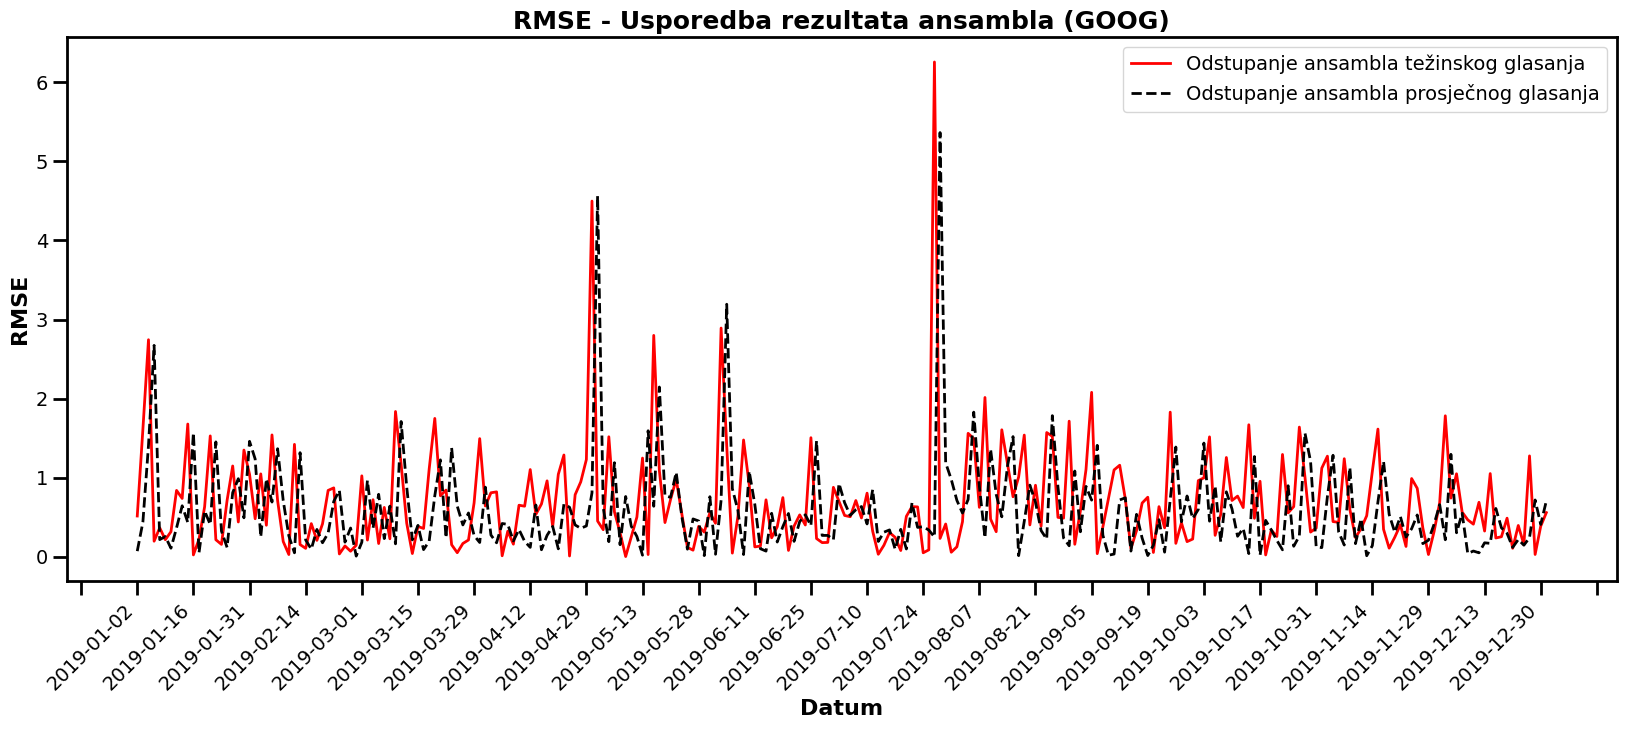

In [ ]:
plot_data = df_prices.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot RMSE values with increased line thickness
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje ansambla težinskog glasanja', color='red', linewidth=2)
plt.plot(plot_data["Date"], rmse_values_avg, label='Odstupanje ansambla prosječnog glasanja', linestyle='--', color='black', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - Usporedba rezultata ansambla (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


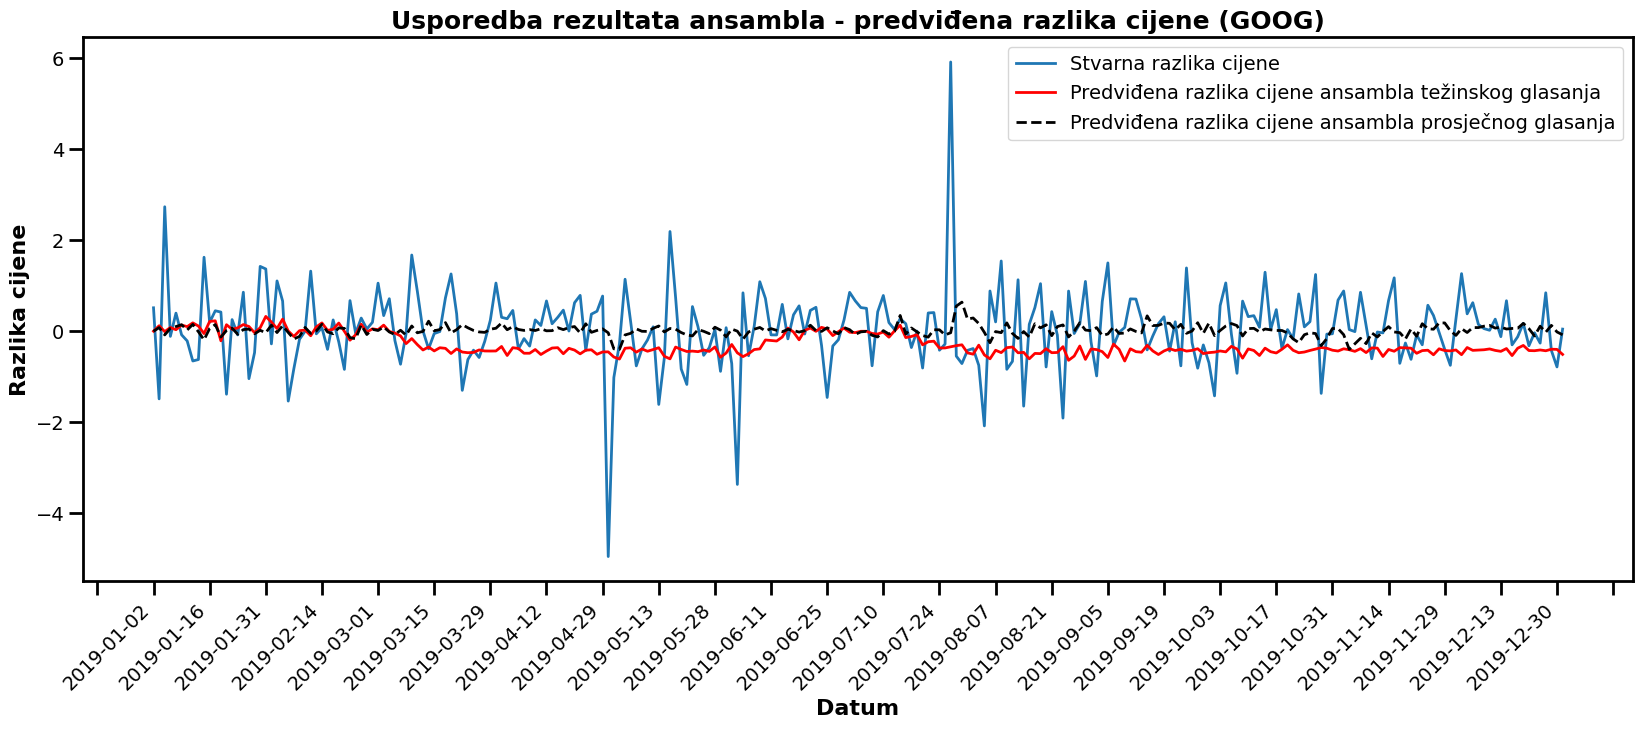

In [ ]:
plot_data = df_prices.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot actual values and predictions with increased line thickness
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], final_predictions, label='Predviđena razlika cijene ansambla težinskog glasanja', color='red', linewidth=2)
plt.plot(plot_data["Date"], predictions_avg, label='Predviđena razlika cijene ansambla prosječnog glasanja', linestyle='--', color='black', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('Usporedba rezultata ansambla - predviđena razlika cijene (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


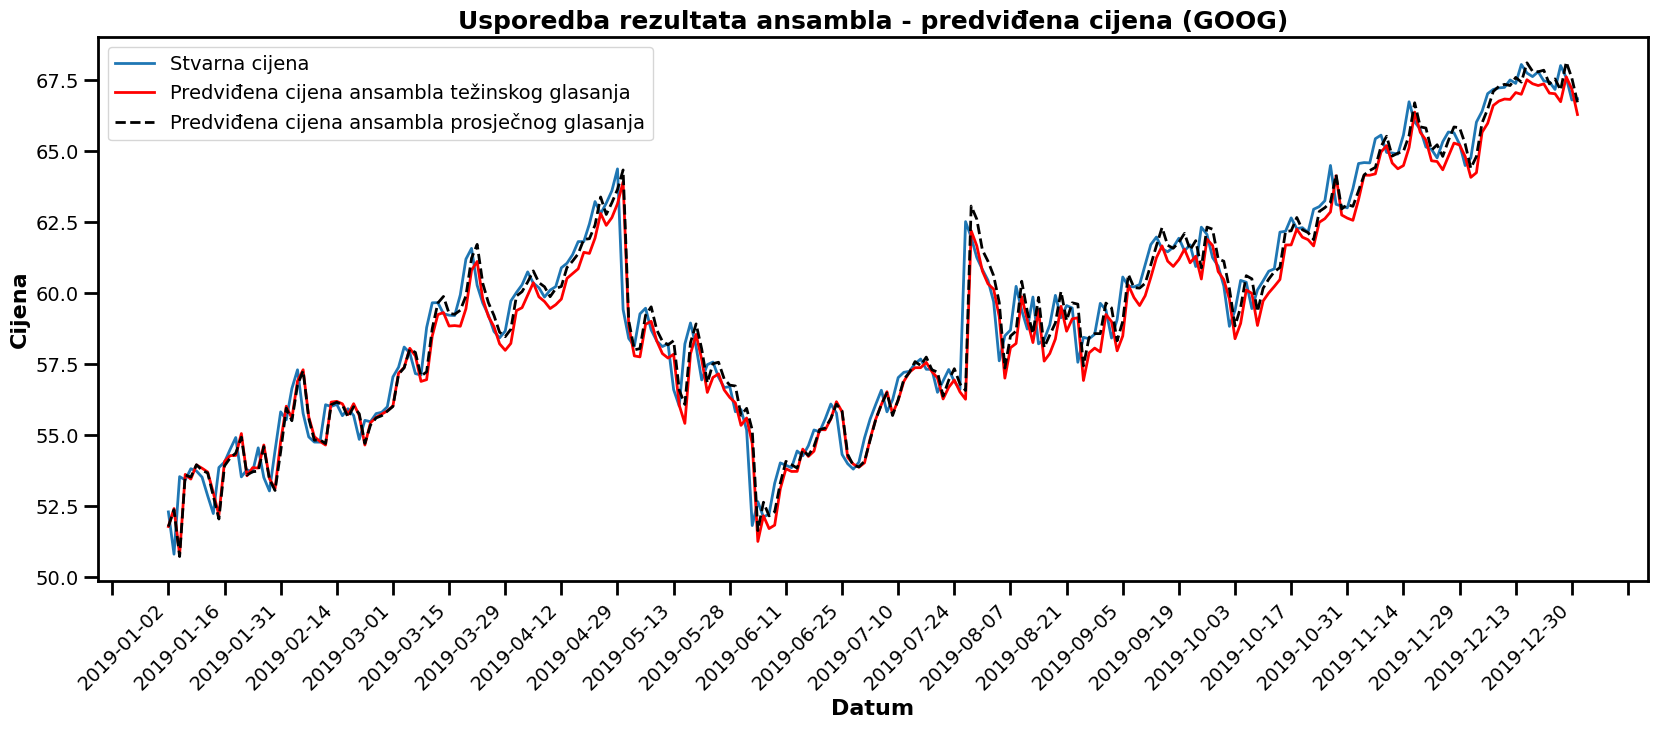

In [ ]:
plot_data = df_prices.copy()
plot_data = plot_data.iloc[train_size:]

plot_data["predicted_diff"] = final_predictions
plot_data["Predicted_price"] = plot_data["Adj_Close"] + plot_data["predicted_diff"]

plt.figure(figsize=(20, 8))

# Plot the actual prices and predictions
plt.plot(plot_data["Date"], plot_data["today_price"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena ansambla težinskog glasanja', color='red', linewidth=2)
plt.plot(plot_data_avg["Date"], plot_data_avg["Predicted_price"], label='Predviđena cijena ansambla prosječnog glasanja', linestyle='--', color='black', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('Usporedba rezultata ansambla - predviđena cijena (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


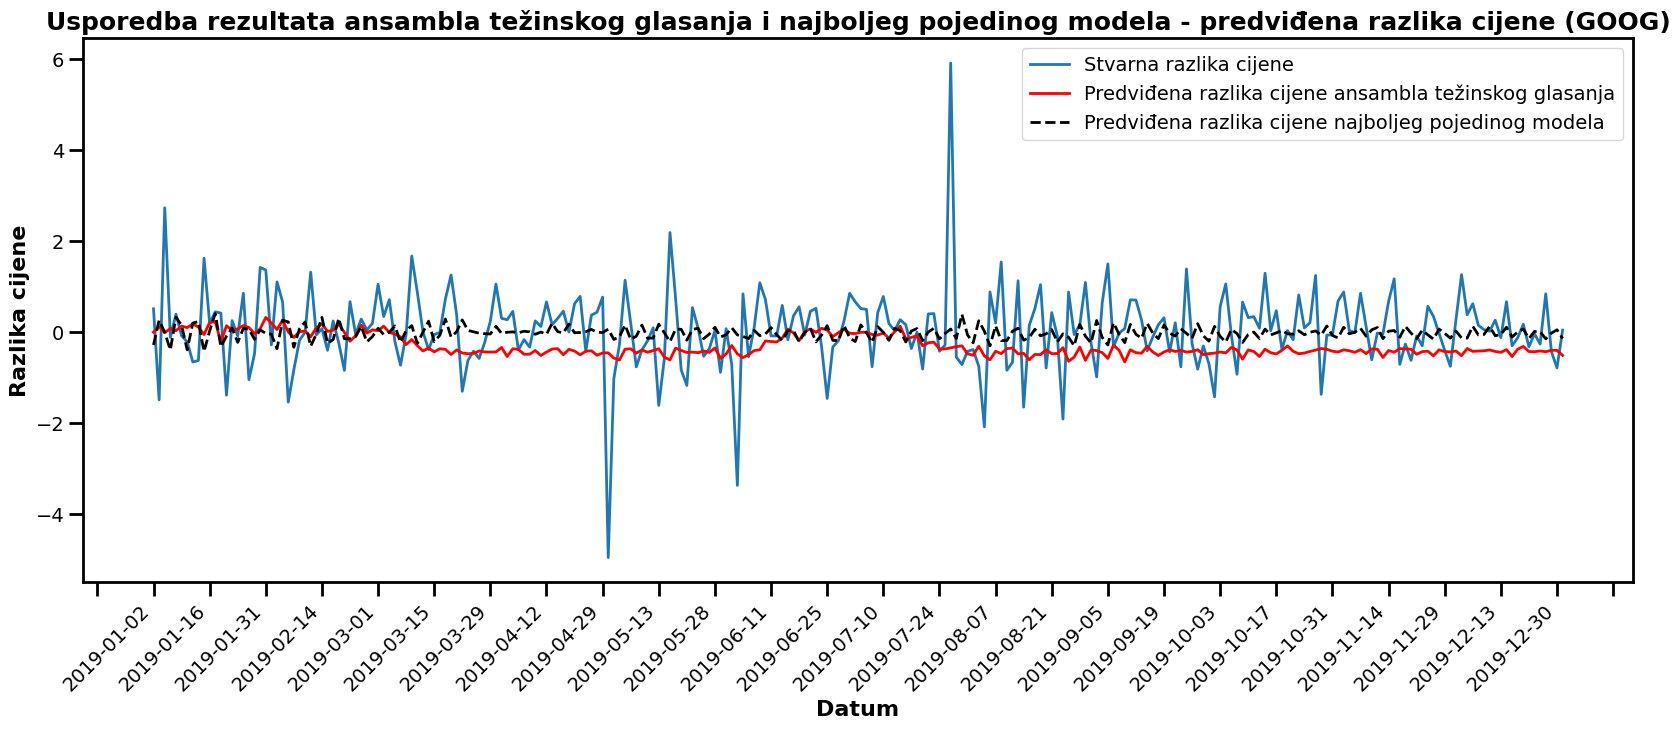

In [ ]:
plot_data = df_prices.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot actual values and predictions
plt.plot(plot_data["Date"], actual_values, label='Stvarna razlika cijene', linewidth=2)
plt.plot(plot_data["Date"], final_predictions, label='Predviđena razlika cijene ansambla težinskog glasanja', color='red', linewidth=2)
plt.plot(plot_data["Date"], predictions_model_1_avg, label='Predviđena razlika cijene najboljeg pojedinog modela', linestyle='--', color='black', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Razlika cijene', fontsize=16, fontweight='bold')
plt.title('Usporedba rezultata ansambla težinskog glasanja i najboljeg pojedinog modela - predviđena razlika cijene (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


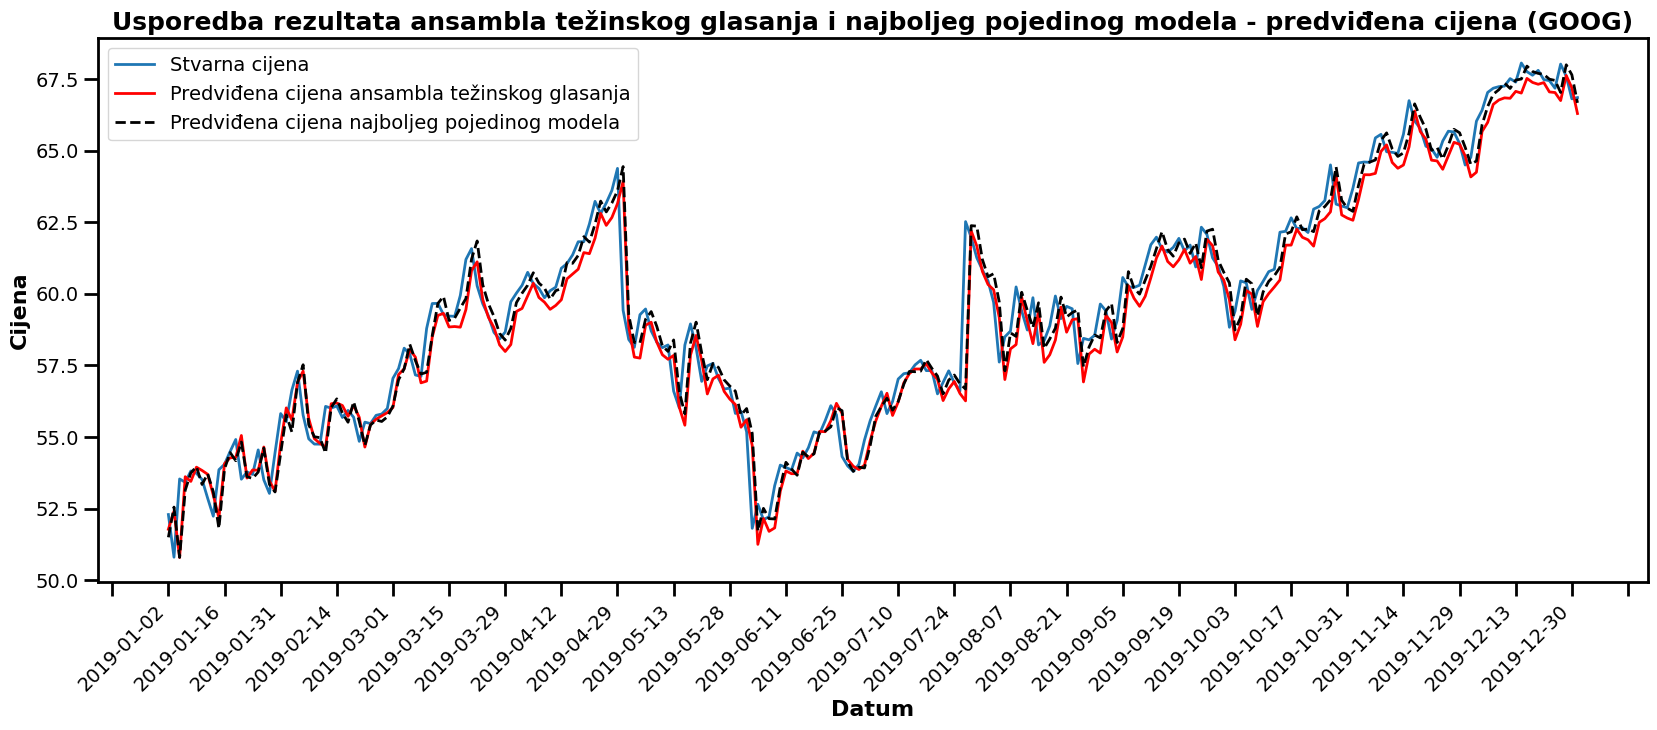

In [ ]:
plot_data = df_prices.copy()
plot_data = plot_data.iloc[train_size:]

# Compute predicted prices
plot_data["predicted_diff"] = final_predictions
plot_data["Predicted_price"] = plot_data["Adj_Close"] + plot_data["predicted_diff"]

plot_data["predicted_diff_avg"] = predictions_model_1_avg
plot_data["Predicted_price_avg"] = plot_data["Adj_Close"] + plot_data["predicted_diff_avg"]

plt.figure(figsize=(20, 8))

# Plot actual and predicted prices
plt.plot(plot_data["Date"], plot_data["today_price"], label='Stvarna cijena', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price"], label='Predviđena cijena ansambla težinskog glasanja', color='red', linewidth=2)
plt.plot(plot_data["Date"], plot_data["Predicted_price_avg"], label='Predviđena cijena najboljeg pojedinog modela', linestyle='--', color='black', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('Cijena', fontsize=16, fontweight='bold')
plt.title('Usporedba rezultata ansambla težinskog glasanja i najboljeg pojedinog modela - predviđena cijena (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()


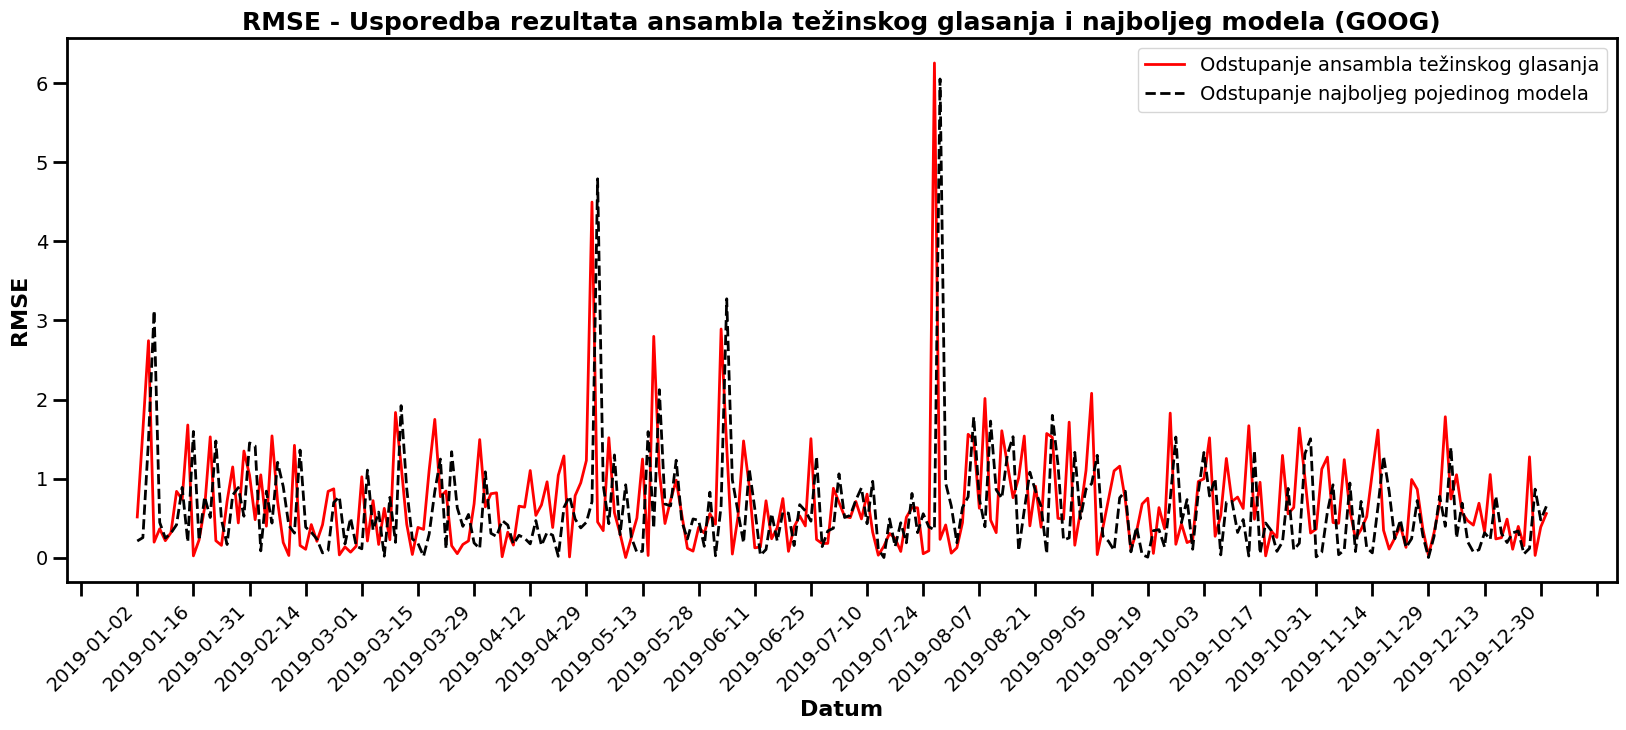

In [ ]:
arima_garch_rmse = np.sqrt((actual_values_avg - predictions_model_1_avg) ** 2)

plot_data = df_prices.copy()
plot_data = plot_data.iloc[train_size:]

plt.figure(figsize=(20, 8))

# Plot RMSE values
plt.plot(plot_data["Date"], rmse_values, label='Odstupanje ansambla težinskog glasanja', color='red', linewidth=2)
plt.plot(plot_data["Date"], arima_garch_rmse, label='Odstupanje najboljeg pojedinog modela', linestyle='--', color='black', linewidth=2)

# Set major ticks interval for x-axis and rotate date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.gcf().autofmt_xdate(rotation=45)

# Increase the thickness of the axis and tick marks
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.tick_params(axis='both', which='major', labelsize=14, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)

# Set font properties for xlabel, ylabel, and title
plt.xlabel('Datum', fontsize=16, fontweight='bold')
plt.ylabel('RMSE', fontsize=16, fontweight='bold')
plt.title('RMSE - Usporedba rezultata ansambla težinskog glasanja i najboljeg modela (GOOG)', fontsize=18, fontweight='bold')

# Customize the legend
plt.legend(fontsize=14, loc='best', frameon=True)

plt.show()
